In [34]:
from skimage import io
import napari
from brainlit.preprocessing.image_process import compute_frags, split_frags, remove_somas, label_points
from brainlit.algorithms import dynamic_programming_viterbi2
import h5py
from skimage import measure
import numpy as np
import time
import matplotlib.pyplot as plt 

In [42]:
size=1100
im = np.zeros((size, size, 1))
for row in np.arange(0, size, 10):
    im[row,:] = 1
labels = im.astype('int')


In [43]:
new_labels = compute_frags(soma_coords=[], labels=labels, im_processed = im, threshold = 0.9, res=[1,1,1])

removing somas: 0it [00:00, ?it/s]
remove small fragments: 100%|██████████| 17380/17380 [00:16<00:00, 1046.57it/s]


Text(0.5, 1.0, 'Fragment Computation Runtime')

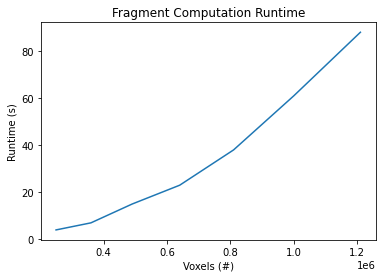

In [44]:
sizes = [500,600, 700, 800, 900, 1000, 1100]
times = [4, 7, 15, 23, 38, 61, 88]
voxels = [size**2 for size in sizes]
plt.plot(voxels, times)
plt.xlabel("Voxels (#)")
plt.ylabel("Runtime (s)")
plt.title("Fragment Computation Runtime")

In [2]:
im = io.imread("/Users/thomasathey/Documents/mimlab/mouselight/input/images/first10_quantitative/images/2018-08-01_0_first10_quantitative.tif")
scale = [0.3, 0.3, 1]
soma_coords = [[360, 240, 120]]
threshold = 0.9

pred_path ="/Users/thomasathey/Documents/mimlab/mouselight/input/images/first10_quantitative/2018-08-01_0_first10_quantitative_Probabilities.h5"
f = h5py.File(pred_path, 'r')
pred = f.get('exported_data')
pred = pred[:,:,:,1]


mask = pred > threshold
labels = measure.label(mask)

In [3]:
t1 = time.perf_counter()
new_labels = compute_frags(soma_coords=soma_coords, labels=labels, im_processed = pred, threshold = threshold, res=scale, chunk_size=[200,200,200], ncpu=8)
#new_labels2 = split_frags(soma_coords=soma_coords, labels=labels, im_processed = pred, threshold = threshold, res=scale)
print(time.perf_counter()-t1)

Parallelizing with 8 cpus


/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
removing somas: 0it [00:00, ?it/s]
looking for components to remove:  22%|██▏       | 29/130 [00:00<00:00, 281.66it/s]/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
removing somas: 0it [00:00, ?it/s]
Adding points...:  25%|██▍       | 7157/28921 [00:00<00:00, 66086.86it/s]/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python

16.211377119


In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im, name="image", scale=scale)
viewer.add_labels(labels, name="labels", scale=scale)
viewer.add_labels(new_labels, name="labels", scale=scale)
#viewer.add_labels(new_labels2, name="labels", scale=scale)

In [4]:
_, soma_lbls = label_points(new_labels, soma_coords, scale)
t1 = time.perf_counter()
mpnp = dynamic_programming_viterbi2.most_probable_neuron_path(image=im.astype(float), labels=new_labels, soma_lbls=soma_lbls, resolution=scale, coef_dist=10, coef_curv=1000)
print(time.perf_counter()-t1)


Setting up emission distribution...
18.241046716000003


In [5]:
mpnp.frags_to_lines(ncpu=8)

Parallelizing x8


/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays

In [6]:
t1 = time.perf_counter()
mpnp.reset_dists(type="all")
mpnp.compute_all_costs_dist_par(point_point_func=mpnp.point_point_dist, point_blob_func=mpnp.point_blob_dist, ncpu=8)
print(time.perf_counter()-t1)

Parallelizing x8


Normalizing: 100%|██████████| 3361/3361 [00:00<00:00, 11937.96it/s]

83.93235287000002


smart pairs=174s

all pairs =307s

allpairs ncpu=8: 92

In [11]:
t1 = time.perf_counter()
mpnp.reset_dists(type="int")
mpnp.compute_all_costs_int_par(ncpu=8)
print(time.perf_counter()-t1)

Parallelizing x8


filling in costs: 100%|██████████| 11296321/11296321 [00:05<00:00, 2195798.70it/s]

33.43447029599997


before: 84

ncpu=1: 82

ncpu=8: 33

In [ ]:
mpnp.state_to_comp[3]

('fragment',
 2,
 {'coord1': [20, 89, 48],
  'orientation1': array([-0.14744196, -0.88465174, -0.44232587]),
  'coord2': [19, 83, 45],
  'orientation2': array([0.14744196, 0.88465174, 0.44232587]),
  'soma connection point': None})